# NIFC v. Williams Flat Comparison Prototype - Final Perims Only*
** NIFC inconsistent labelings makes it difficult to confirm final state (as seen by Williams elimination); instead may be best to opt to iterating through all evolutions and finding matches (or closest ones with a verbose warning)**

Workflow:
- Download NIFC perimeter set
- sync w/ s3 to access for DPS
- Clean/query set
- Import final Williams perim (+ evolutions if available)
- Compare final v. final (interminent + intermin if available)
- Report back stats + visualization

Notes:
- ogr vs. gpd usage (and consequential computing cost)

References:
- SQL shp querying: https://gis.stackexchange.com/questions/390839/sql-request-with-a-shapefile-data-with-python
- 

In [9]:
import osgeo
import geopandas as gpd
import pandas as pd
from osgeo import ogr
import numpy as np
from matplotlib import pyplot as plt
import os
# import rioxarray as rio
import xarray as xr
import rasterio
import glob
# from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import shapely.speedups
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
from datetime import datetime

In [13]:
# Yang's quality filter
"""
NIFC_fire 
= NIFC_allfires[(NIFC_allfires.IncidentNa==firename)
& (NIFC_allfires.GDB_FROM_D.values
!= None)

& (NIFC_allfires.FeatureCat
== 'Wildfire Daily Fire Perimeter')

& (NIFC_allfires.IsVisible
== 'Yes')]
"""

"\nNIFC_fire \n= NIFC_allfires[(NIFC_allfires.IncidentNa==firename)\n& (NIFC_allfires.GDB_FROM_D.values\n!= None)\n\n& (NIFC_allfires.FeatureCat\n== 'Wildfire Daily Fire Perimeter')\n\n& (NIFC_allfires.IsVisible\n== 'Yes')]\n"

In [14]:
# check on download status in case failed fetch

# all fires till 2021
# source: https://data-nifc.opendata.arcgis.com/datasets/nifc::interagencyfireperimeterhistory-all-years-view/explore?location=29.495306%2C-122.087025%2C3.52&showTable=true
perims_path = "/projects/my-public-bucket/InterAgencyFirePerimeterHistory"
usa_path = "/projects/my-public-bucket/USAShapeFile"

In [15]:
# change the global options that Geopandas inherits from
pd.set_option('display.max_columns',None)

# gpd method (comp. slower)
df = gpd.read_file(perims_path)
# print data table
#df.head()

# US map
usa = gpd.read_file(usa_path)


In [16]:
# replicating filtering

# visible aka non empty
non_empty = df[df.geometry != None]
print(f'Non_empty length: {len(non_empty)}')
non_null = non_empty[non_empty.GIS_ACRES != 0]
finalized_perims = non_null
""" Final perimeter rid of valid perim, not reliable !!! """
# finalized_perims = non_empty[non_empty.FEATURE_CA == 'Wildfire Final Perimeter']
finalized_perims.head()

# if 'FEATURE_CA' in finalized_perims.columns:
    # print('col in coluns')

Non_empty length: 24747


,OBJECTID,MAP_METHOD,DATE_CUR,COMMENTS,GEO_ID,IRWINID,UNQE_FIRE_,FIRE_YEAR,LOCAL_NUM,INCIDENT,UNIT_ID,POO_RESP_I,FEATURE_CA,GIS_ACRES,USER_NAME,SOURCE,AGENCY,FIRE_YEAR_,Shape__Are,Shape__Len,geometry
0,1,Image Interpretation,20210903,Perimeter update using Sentinel-2 imagery.,1,{9FABE71D-843F-4624-859C-A7EC4A72AB89},2021-AKUYD-000223,2021,000223,Cultas Creek,AKYCP,AKUYD,Wildfire Final Perimeter,40450.0,None,AICC,AFS,2021.0,9.273137e+08,528166.832442,"POLYGON ((-142.81944 65.16774, -142.81904 65.1..."
1,2,Image Interpretation,20210903,Perimeter updated using Sentinel-2 imagery.,2,{C5ED6535-8217-4130-B795-E81AE6BF02D1},2021-AKUYD-000309,2021,000309,Crescent Creek,AKYCP,AKUYD,Wildfire Final Perimeter,1384.0,None,AICC,AFS,2021.0,3.115264e+07,56968.266410,"POLYGON ((-143.66148 64.97452, -143.65997 64.9..."
2,3,Image Interpretation,20210901,Perimeter updated using Sentinel-2 imagery.,3,{D9F72569-F8CD-45DB-93F7-D7D05C4F4723},2021-AKFAS-000397,2021,000397,Salcha River 2,AKDNS,AKFAS,Wildfire Final Perimeter,2828.1,None,AICC,DOF,2021.0,6.324108e+07,118033.611976,"MULTIPOLYGON (((-145.24616 64.90080, -145.2455..."
3,4,Image Interpretation,20210901,Perimeter updated using Sentinel-2 imagery.,4,{3B2C6FF0-CE08-4960-AC83-45DC5687A090},2021-AKUYD-000405,2021,000405,Whitefish Lake,AKYFR,AKUYD,Wildfire Final Perimeter,417.5,None,AICC,AFS,2021.0,1.036802e+07,16248.978885,"POLYGON ((-142.40339 66.24461, -142.40385 66.2..."
4,5,Image Interpretation,20210901,Perimeter updated using Sentinel-2 imagery.,5,{C0CFD381-B561-4704-BA86-311CF4BE126D},2021-AKUYD-000399,2021,000399,South Fork,AKEID,AKUYD,Wildfire Final Perimeter,884.6,None,AICC,AFS,2021.0,2.040334e+07,44186.061518,"POLYGON ((-144.39133 65.30406, -144.39133 65.3..."


In [ ]:
# master plot of the identified features
# df.plot()

## Williams Flat Import and Comparison

Ultimately in this version we are only concerned with the `perimeter` of the final shape (not the evolution; comparison will come later)

In [17]:
# Williams ID based path
lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/*4655*') ## ID of William's Flats
#lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/*6388*') ## ID of William's Flats

# unique lf ids if more than one, but works with only one too!
lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
print('Number of LF ids:',len(lf_ids)) # Should be one, just william's flats

Number of LF ids: 1


In [18]:
# each largefire id has a file for each timestep which has entire evolution up to that point.
# the latest one has the most up-to-date info for that fire
largefire_dict = dict.fromkeys(lf_ids)
for lf_id in lf_ids:
    most_recent_file = [file for file in lf_files if lf_id in file][-1]
    largefire_dict[lf_id] = most_recent_file
print(largefire_dict[lf_id])
print(lf_ids)

/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/F4655_20190830PM
['F4655']


### Extract final perimeter of incident with max() timestamp

- Includes additional work on evolving fire perimeters 
- Looks like 'fireline' layer holds proper evolution -> resolving plotting issue in slack

In [ ]:
# try: applying format 
impacted = year_perims

impacted['DATE_NOT_NONE'] = impacted.apply(lambda row : row.DATE_CUR is not None, axis = 1)
impacted = impacted[impacted.DATE_NOT_NONE == True]

impacted['DATE_LEN_VALID'] = impacted.apply(lambda row : len(row.DATE_CUR) == 8 , axis = 1)
impacted = impacted[impacted.DATE_LEN_VALID == True]

cur_format = '%Y%m%d' 
impacted['DATE_CUR_STAMP'] =  impacted.apply(lambda row : datetime.strptime(row.DATE_CUR, cur_format), axis = 1)
print(impacted['DATE_CUR_STAMP'])


In [ ]:
print(sample_timestamp.hour)
print(impacted.iloc[[0]].DATE_CUR_STAMP.max().hour)

print(type(sample_timestamp.day))

range_test = 9
me = range(1, range_test)
for i in me:
    print(i)

In [ ]:
# NEW: dict key search styled search

# make a list of all stamps
print(sample_timestamp)
transformed = impacted.DATE_CUR_STAMP.tolist()
# print(transformed)
cloz_dict = {
  abs(sample_timestamp.timestamp() - date.timestamp()) : date
  for date in transformed}

res = cloz_dict[min(cloz_dict.keys())]
print("Nearest date from list : " + str(res))

print(type(res))
print(res.day)

print(abs(sample_timestamp.day-res.day))

# find matching rows of impacted['DATE_CUR_STAMP']
finalizedy = impacted[impacted['DATE_CUR_STAMP'] == res]
print(len(finalizedy))

In [ ]:
# try: closest timestamp match
sample_timestamp = fireline.iloc[[0]].t.max()
# print(type(sample_timestamp))
# note: datecure contains time series vs time stamp
# print(type(impacted.iloc[[0]].DATE_CUR_STAMP.max())) # timestamp
# print(type(impacted.iloc[[0]].DATE_CUR_STAMP)) # series

# if not none, other match also sufficnet -> concat/make list

# since get_loc was presenting type issues -> self define
def get_nearest(dataset, timestamp):
    """ Identify rows of dataset with timestamp matches;
        expects year, month, date in datetime format
        
        dataset: input dataset to search for closest match
        timestamp: timestamp we want a close match for 
        
        returns: dataset with d->m->y closest matches
    """
    
    # reset best matches
    index_day = None
    index_month = None
    index_year = None
    
    for l in range(dataset.shape[0]):
        curr = dataset.iloc[[l]].DATE_CUR_STAMP.max()
        if curr.year != sample_timestamp.year:
            # at least want matching year
            continue
        if curr.day == sample_timestamp.day and curr.month == sample_timestamp.month:
            print('Identified match by day')
            if type(index_day) is int:
                # multiple options
                index_day = [index_day] # transform type
                index_day.append(l)

            elif type(index_day) is list:
                # already list -> concat
                index_day.append(l)
            else:
                index_day = l
        # elif curr.month == sample_timestamp.month:

    # type adjustment
    # if type(index_day) not list:
        # index_day = [index_day]
        
    # fetch rows 
    finalized = dataset.iloc[index_day]
    
    return finalized

results = get_nearest(impacted, sample_timestamp)
print(results.shape[0])
print(results.DATE_CUR_STAMP)
print('vs. original stamp')
print(sample_timestamp)

#### DEPRECATED

# def get_nearest(data, timestamp):
    # print(f'Timestamp type: {type(timestamp)}')
    # index = data.index.get_loc(timestamp,method="nearest")
    # return data.iloc[index, 0]

# TRY: get_loc method 
# impacted['DATE_CUR_STAMP'] = [get_nearest(impacted, sample_timestamp)]


In [20]:
# try: sorting dataset w/ time
fid = lf_ids[0]
layer = 'perimeter'
# print(gdf.t)
gdf = gpd.read_file(largefire_dict[lf_id],layer=layer)
gdf = gdf.sort_values(by='t',ascending=False)
# print(gdf.t)

print(gdf.iloc[[3]].t) # year - month - day
# print(year_perims.iloc[[0]].DATE_CUR.max()) # year - month - day
# print(year_perims.iloc[[9]].DATE_CUR.max())

38   2019-08-29
Name: t, dtype: datetime64[ns]


In [ ]:
# try: applying lambda function to transform and make new col of year perims
# print(year_perims['DATE_CUR'])
print(len(year_perims.iloc[[0]].DATE_CUR.max()))
print(year_perims.iloc[[0]].DATE_CUR.max())
print(type(year_perims.iloc[[0]].DATE_CUR.max()))

validity = [len(str(year_perims.iloc[[k]].DATE_CUR.max())) == 8 for k in range(year_perims.shape[0])]
validity_2 = [year_perims.iloc[[k]].DATE_CUR.max() is not None for k in range(year_perims.shape[0])]
# [print(year_perims.iloc[[k]].DATE_CUR.max()) for k in range(year_perims.shape[0])]

# print(validity_2)
print(f'Is False in validity_2? -> {False in validity_2}')

# manual counting of none instances
counter_non = 0
for j in range(year_perims.shape[0]):
    if year_perims.iloc[[j]].DATE_CUR.max() is None:
        counter_non += 1
        
print(f'true manual count of None instances: {counter_non}')

# @TODO: picking up signs for none values --> need to take care of despite indiv not sensing?

year_perims['DATE_NOT_NONE'] = year_perims.apply(lambda row : row.DATE_CUR is not None, axis = 1)
print(year_perims['DATE_NOT_NONE'])
print('Before removing None data values')
print(len(year_perims))
print('After forecful removal')
limited = year_perims[year_perims['DATE_NOT_NONE'] == True]
print(len(limited))

# @TODO: finalize date validity by length
print(f'before datavlid filtering: {year_perims.shape[0]}')
year_perims['DATE_VALID'] = limited.apply(lambda row : len(row.DATE_CUR) == 8 , axis = 1)
print(year_perims['DATE_VALID'])
newer = year_perims[year_perims.DATE_VALID == True]
print(f'after datavlid filtering: {newer.shape[0]}')

    
# year_perims['DATE_CUR_STAMP'] = df.apply(lambda row :  datetime.strptime(row['DATE_CUR'], '%Y%m%d'), axis = 1)
# print(year_perims['DATE_CUR_STAMP'])


In [ ]:
# gdf loc for object id
print(gdf.iloc[[5]].index)
print(gdf.iloc[[5]])

57
    n_pixels  n_newpixels       farea     fperim  flinelen  duration  \
14      2057            0  185.537556  70.933416       0.0       8.0   
37      2057            0  185.537556  70.933416       0.0       8.0   
15      2057            0  185.537556  70.933416       0.0       8.0   
38      2057            0  185.537556  70.933416       0.0       8.0   
16      2057            0  185.537556  70.933416       0.0       8.0   

       pixden  meanFRP                   t  \
14  11.086704      0.0 2019-08-30 12:00:00   
37  11.086704      0.0 2019-08-30 00:00:00   
15  11.086704      0.0 2019-08-29 12:00:00   
38  11.086704      0.0 2019-08-29 00:00:00   
16  11.086704      0.0 2019-08-28 12:00:00   

                                             geometry  
14  POLYGON ((-1372528.465 488491.549, -1372534.54...  
37  POLYGON ((-1372528.465 488491.549, -1372534.54...  
15  POLYGON ((-1372528.465 488491.549, -1372534.54...  
38  POLYGON ((-1372528.465 488491.549, -1372534.54...  
16  POL

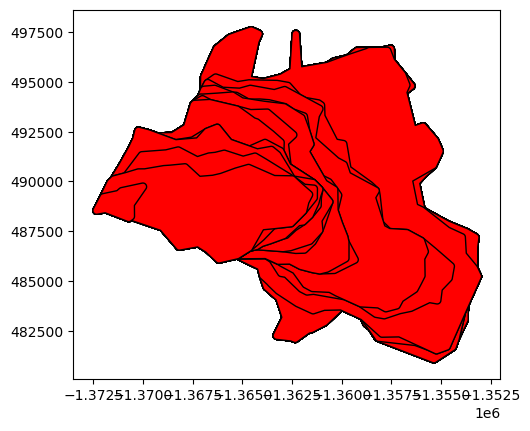

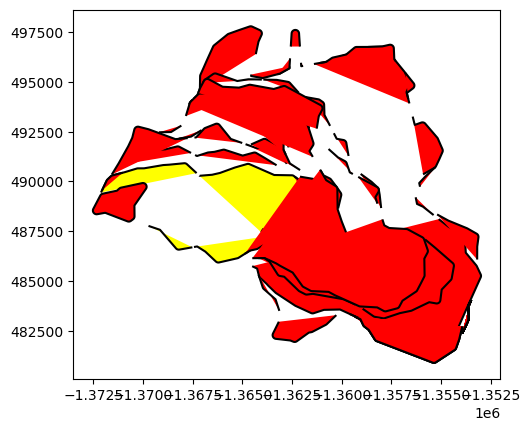

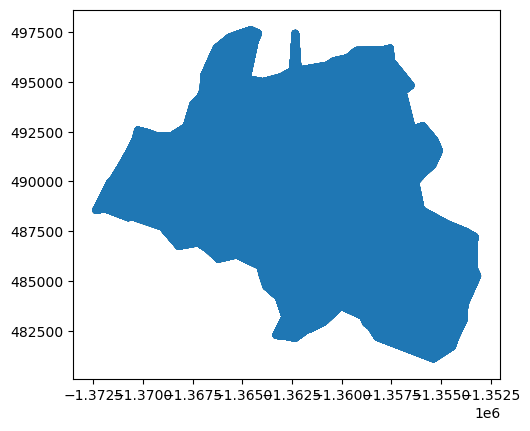

In [24]:
# read perimeter of existing line
fid = lf_ids[0]
layer = 'perimeter'
gdf = gpd.read_file(largefire_dict[lf_id],layer=layer)

# ADDED: time change:
gdf = gdf.sort_values(by='t',ascending=False)

# fireline display (evolution)
fireline = gpd.read_file(largefire_dict[fid],layer='fireline') # Not super interesting, just shapefiles an time
# fireline['t'] = fireline['t'].astype("str")

max_timestamp = gdf.t.max()
print(gdf.shape[0])
print(gdf.head())

plot_perims = True
ax_undefined = True
# iterate and plot per entry
if plot_perims:
    print('VERBOSE: try plotting largefire perim history collection')
    print(f'show gdf entries: {gdf.shape[0]}')
    for i in range(gdf.shape[0]):
        current = gdf.iloc[[i]]
        if ax_undefined:
            ax = current.plot(facecolor="yellow", edgecolor="black", legend=True) 
            ax_undefined = False
        else:
            current.plot(facecolor="red", edgecolor="black", ax=ax)
        # current.plot(facecolor="orange", edgecolor="black")

print('VERBOSE: try plotting fireline evolution')
# TRY: plotting firelines for results
ax_undefined = True
print(f'CRS of entire fireline set: {fireline.crs}')
for i in reversed(range(fireline.shape[0])):
    current = fireline.iloc[[i]]
    if ax_undefined:
        ax = current.plot(facecolor="yellow", edgecolor="black") 
        ax_undefined = False
    else:
        current.plot(facecolor="red", edgecolor="black", ax=ax)
    # current.plot(facecolor="orange", edgecolor="black")
    

# rename for convennience
finalized_williams = gdf

print('GDF/perimeter layern dimensions:')
print(gdf.shape)

# take max t 
print('Final Willaims perim/max time')
finalized_williams.plot()

# try: fireline year extraction / uniqueness detection
# print(fireline['t'].nunique())
# print(fireline.iloc[[0]].t)
# print(fireline.iloc[[0]].t.max())
print(finalized_williams.iloc[[0]].t.max().year)

sample_year = fireline.iloc[[0]].t.max().year
year_matching = [sample_year ==  fireline.iloc[[j]].t.max().year for j in range(fireline.shape[0])]
checked = False in year_matching
print(f'Resulting year check: {checked}')


## With loaded files: Direct querying with year + location

Note:  Improve querying with state filtering? --> hard given Williams has no associated state, best to directly query with intersect

Attempting set_crs...
Failure: attempting to_crs application
epsg:9311
epsg:9311
Number of extracted_year matches from treated perims: 888
<class 'pyproj.crs.crs.CRS'>


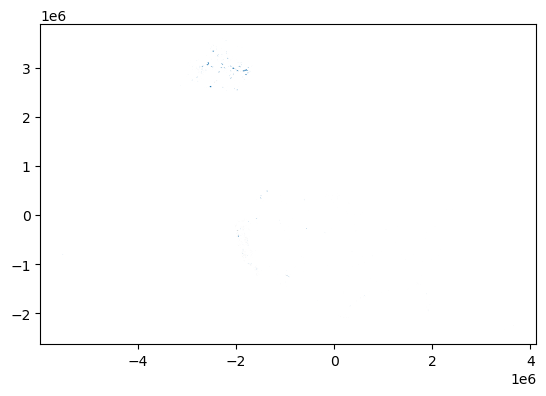

In [25]:
# treated perims
finalized_williams = finalized_williams.iloc[[0]].head() 
# assume no crs is set -> if false then to crs to adjust
try:
    print('Attempting set_crs...')
    finalized_perims.set_crs(finalized_williams.crs)
except: 
    print('Failure: attempting to_crs application')
    print(finalized_williams.crs)
    finalized_perims = finalized_perims.to_crs(finalized_williams.crs)
    print(finalized_perims.crs)

# head not appearing?
# finalized_williams.head()
# gdf.head()

# (1) timestamp year matching

# time stamp to treat finalized_perims - should only be one (final) fire
assert finalized_williams.shape[0] == 1
extracted_year = max_timestamp.year
# print type of attr field -> str --> must convert extracted year
# print(type(finalized_perims.iloc[0]['FIRE_YEAR']))
year_perims = finalized_perims[finalized_perims.FIRE_YEAR == str(extracted_year)]
print(f'Number of extracted_year matches from treated perims: {len(year_perims)}')

# (2) location overlap

# intersect features and only invlude those with an intersection result > 0
year_perims.plot()

print(type(finalized_williams.crs))

In [ ]:
# check meta data tommake sure it matches
print(finalized_williams.crs)
print(year_perims.crs)
assert finalized_williams.crs == year_perims.crs, "CRS mismatch"

In [ ]:
# try: identify units of given dataset
print(year_perims.crs.axis_info[0].unit_name)
print(finalized_williams.crs.axis_info[0].unit_name)
print(type(finalized_williams.crs.axis_info[0].unit_name))
print(year_perims.crs.axis_info[0].unit_name == 'metre')
# check boolean val
print(year_perims.crs.axis_info[0].unit_name == finalized_williams.crs.axis_info[0].unit_name)

In [ ]:
# enable shapely speed ups for querying
shapely.speedups.enable() 
# idea: within may be fully removing anything that isn't encapsulated
intersect_mask = year_perims.within(lowest)
if True in intersect_mask.values:
    print('Identified Intersection')
else: 
    print('No boolean identified intersection')
#print(if True in intersect_mask.values)
finalized = year_perims.loc[intersect_mask]
finalized.plot()
finalized.head() # shows up empty --> intersect 

In [ ]:
# try alternative intersection 
# print(year_perims.geometry)
# print(lowest)
intersect_new = year_perims.geometry.intersects(lowest.geometry)
print(intersect_new)
year_perims_inter = year_perims.loc[intersect_new]
year_perims_inter.plot()

# try non_none (block below define non_none)
# print('attempting picked out williams plot')
# other_inter = year_perims.geometry.intersects(non_none.geometry)
# inter_new_ish = year_perims.loc[other_inter]
# inter_new_ish.plot()

# try iterating per row to see if there is a diff result
for i in range(len(year_perims)):
    curr_row = year_perims.iloc[[i]]
    # inter_temp = curr_row.intersects(lowest)
    # print(inter_temp)

## Investigate: potential causes to empty result:

In [ ]:
# try: inspect geometries of results
print(williams_incident.geometry)
print(year_perims.geometry.geom_type == 'Polygon')
if False in year_perims.geometry.geom_type == 'Polygon':
    print('False picked up')
else:
    print('All uniform geometry')

## GPD Dataframe overlay 

In [ ]:
# cols / extent of date for NIFC set
print(year_perims.head())

## Forced empty geodataframe

In [ ]:
# EMPTY FRAME
# gpd.overlay
lowest = gdf[gdf.t == gdf.t.max()]
print(type(lowest))
print(lowest.dtypes)

# test a non intersecting point
noner = gpd.GeoDataFrame({'geometry': [Point(1, 2)]}, crs=lowest.crs)
print('noner')
print(noner)

resulting = gpd.overlay(year_perims, noner, how='intersection')

print('TYPE FOR RESULTING')
print(type(resulting))
print(resulting)

if resulting.empty:
    print('passed check')

## Nonempty Dataframe for plot comparison

<class 'geopandas.geodataframe.GeoDataFrame'>
n_pixels                int64
n_newpixels             int64
farea                 float64
fperim                float64
flinelen              float64
duration              float64
pixden                float64
meanFRP               float64
t              datetime64[ns]
geometry             geometry
dtype: object
len resuling: 1
19891
<class 'list'>
Unified Plot:
id_matches:
[       OBJECTID    MAP_METHOD  DATE_CUR COMMENTS   GEO_ID IRWINID  \
19890     19891  GPS / Ground  20190814     None  3927959    None   

              UNQE_FIRE_ FIRE_YEAR LOCAL_NUM        INCIDENT UNIT_ID  \
19890  2019-WACOA-190106      2019    190106  Williams Flats   WACOA   

      POO_RESP_I FEATURE_CA  GIS_ACRES      USER_NAME SOURCE AGENCY  \
19890       None   Wildfire    45286.3  Rebecca Peone  WFDSS    BIA   

       FIRE_YEAR_    Shape__Are     Shape__Len  \
19890      2019.0  4.086123e+08  131283.537858   

                                                

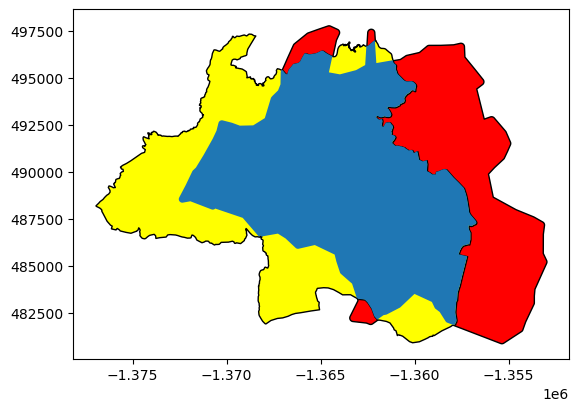

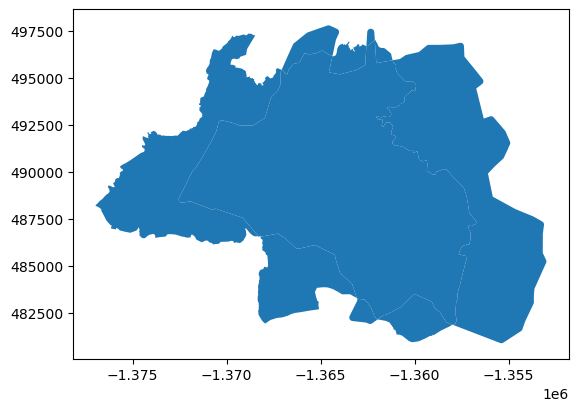

In [26]:
# non empty
lowest = gdf[gdf.t == gdf.t.max()]
print(type(lowest))
print(lowest.dtypes)

resulting = gpd.overlay(year_perims, lowest, how='intersection')


print(f'len resuling: {len(resulting)}')
print(resulting.head().iloc[[0]].OBJECTID.tolist()[0])
print(type(resulting.head().iloc[[0]].OBJECTID.tolist()))

# unified plot
print('Unified Plot:')
# FEDS OUTPUT
ax = lowest.plot(facecolor="red", edgecolor="black", legend=True) 

# NIFC FINDINGS
# iterate over all identified objs in inersect

# all fetched instances stored
id_matches = []

for j in range(resulting.shape[0]):
    objectid_match = resulting.iloc[[j]].OBJECTID.tolist()[0]
    fetched = year_perims[year_perims.OBJECTID == objectid_match]
    fetched.plot(facecolor="yellow", edgecolor="black", ax=ax)
    id_matches.append(fetched)

# NIFC FINDINGS INTERSECTED
resulting.plot(ax=ax)
union = gpd.overlay(fetched, lowest, how='union')
union.plot()

print('id_matches:')
print(id_matches)

# name = finalized_perims[finalized_perims.INCIDENT == name_match]
# williams_incident = name.iloc[[0]]


### Operation tries/plots to verify function behavior

In [27]:
# intersection 
gpd.overlay(year_perims, lowest, how='intersection')
print(type(year_perims)) # should be valid on frame (series is a single col etc)
isinstance(lowest, pd.DataFrame)

<class 'geopandas.geodataframe.GeoDataFrame'>


True

### Simplifiying Geometries

In [44]:
# def feds/nifc area
def areaCalculation(geom_instance):
    """ Calculate area of the object, including
        mult-row instances via loop
        Input: geom data frame instance
        Output: numeric area calculation (units defined in const)
    """
    try:
        area = 0
        for i in range(geom_instance.geometry.area.shape[0]):
            area += geom_instance.geometry.area[i]
    except KeyError:
        # print('Identified key error in areaCalculation(): returning item() based area calc', end='\r')
        area = geom_instance.geometry.area.item()
    
    return area

<class 'geopandas.geodataframe.GeoDataFrame'>
UNION0:
<class 'geopandas.geodataframe.GeoDataFrame'>

IOU0 CALCULATION
0.48815568530707504

IOU200 CALCULATION
0.48978724818788494

IOU300 CALCULATION
0.4901208578908378
NET BOUNDING
0    POLYGON ((-1372542.501 481882.696, -1356714.74...
1    POLYGON ((-1376971.512 480950.836, -1357982.06...
2    POLYGON ((-1368263.119 480900.008, -1352987.33...
dtype: geometry
<class 'geopandas.geoseries.GeoSeries'>
BEFORE FRAME: 
809624676.9389136
REMAKE NET BOUNDING
AFTER FRAME: 
809624676.9389136


<AxesSubplot:>

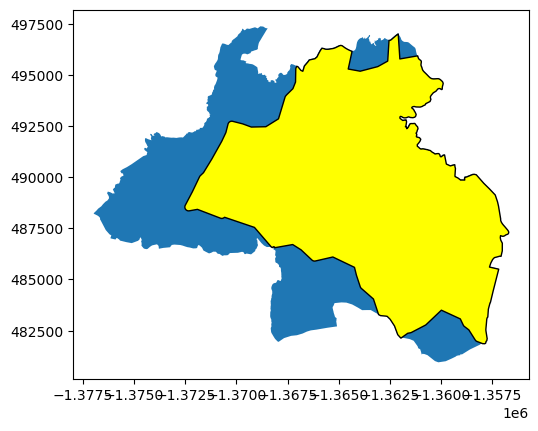

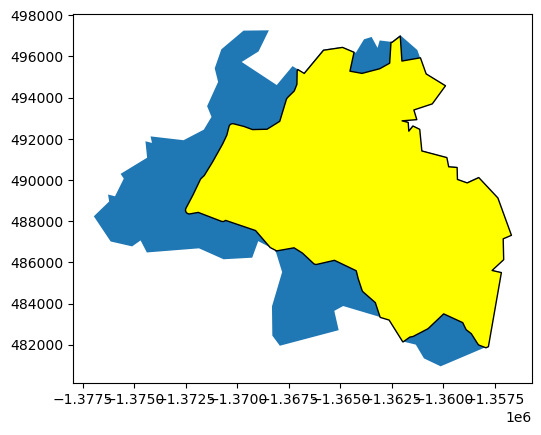

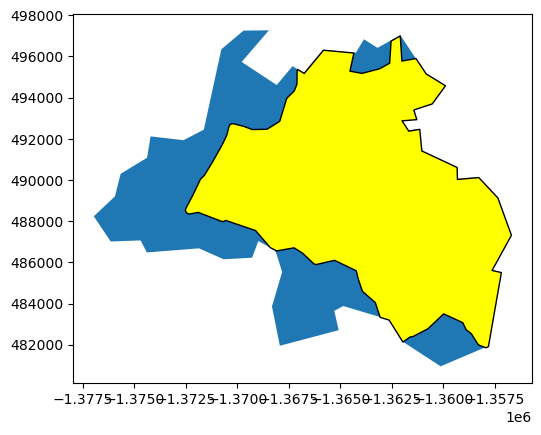

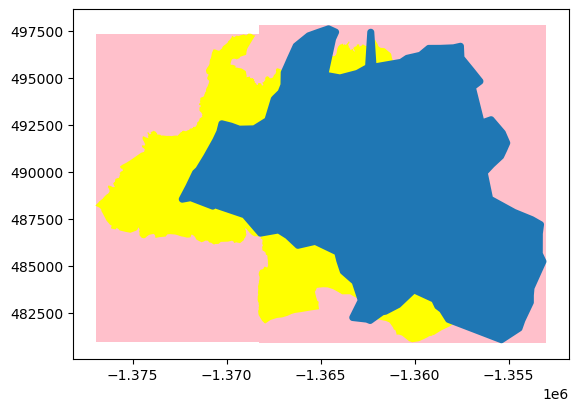

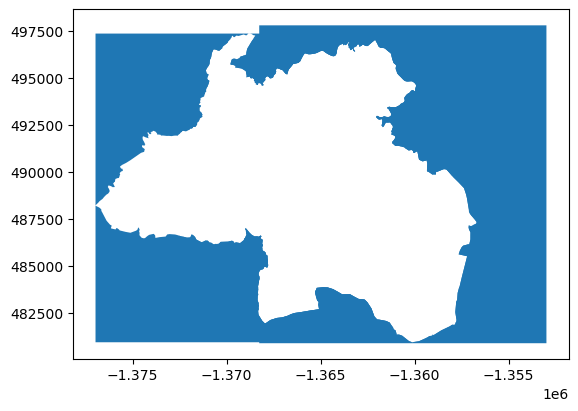

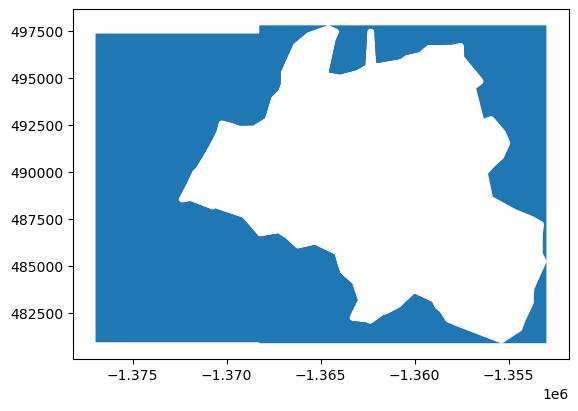

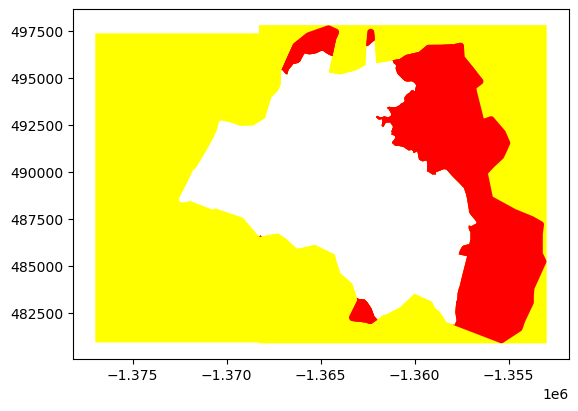

In [45]:
# try: simply geoms 
# finalized_williams.plot() # feds
# fetched.plot(facecolor="yellow", edgecolor="black")

print(type(fetched))
# enter in for series -> need geom
type(fetched.geometry)
# simp = fetched.geometry.simplify(100)
# simp.plot()
# fetched.geometry.simplify(200).plot()
isinstance(fetched, gpd.GeoDataFrame)
# fetched.geometry.simplify(300).plot()

case0 = fetched
case200 =fetched.geometry.simplify(200)
case300 = fetched.geometry.simplify(300)

# FOR DEMO
# try intersecting
ax0 = fetched.plot()
inter0 = gpd.overlay(fetched, lowest, how='intersection')
inter0.plot(facecolor="yellow", edgecolor="black",ax=ax0)

case200 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(case200))
ax200 = case200.plot()
# print(type(case200))
inter200 = gpd.overlay(case200, lowest, how='intersection')
inter200.plot(facecolor="yellow", edgecolor="black",ax=ax200)

case300 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(case300))
ax300 = case300.plot()
# print(type(case300))
inter300 = gpd.overlay(case300, lowest, how='intersection')
inter300.plot(facecolor="yellow", edgecolor="black",ax=ax300)

union0 = gpd.overlay(case0, lowest, how='union')
union200 = gpd.overlay(case200, lowest, how='union')
union300 = gpd.overlay(case300, lowest, how='union')

# per each: get area and divide for ratios]
print('UNION0:')
print(type(union0))
# iterate and sume union0 area
sum1 = 0
# print(union0.head())
for i in range(union0.geometry.area.shape[0]):
    sum1 += union0.geometry.area[i]
iou0 = inter0.geometry.area.item() / sum1

sum2 = 0
for i in range(union200.geometry.area.shape[0]):
    sum2 += union200.geometry.area[i]
iou200 = inter200.geometry.area.item() / sum2

sum3 = 0
for i in range(union300.geometry.area.shape[0]):
    sum3 += union300.geometry.area[i]
iou300 = inter300.geometry.area.item() / sum3

print('')
print('IOU0 CALCULATION')
print(iou0)

print('')
print('IOU200 CALCULATION')
print(iou200)

print('')
print('IOU300 CALCULATION')
print(iou300)

# Try: bounding box
union0 = union0
print('NET BOUNDING')
net_bounding = union0.geometry.envelope
print(net_bounding)
ax = net_bounding.plot(facecolor='pink')
case0.plot(facecolor = 'yellow',ax=ax)
lowest.plot(ax=ax)

print(type(net_bounding))
# make net bounding into frame
print('BEFORE FRAME: ')
print(areaCalculation(net_bounding))
print('REMAKE NET BOUNDING')
net_bounding = net_bounding.to_frame()
print('AFTER FRAME: ')
print(areaCalculation(net_bounding))

# try bounding - existing cas0
result = gpd.overlay(net_bounding, case0, how='difference') # nifc
result.plot()
result2 = gpd.overlay(net_bounding, lowest, how='difference') # feds 
result2.plot()
jf = result2.plot(facecolor = 'yellow')
result.plot(facecolor = 'yellow',ax=jf)
gpd.overlay(result, lowest,keep_geom_type=False, how='intersection').plot(facecolor= 'red',ax=jf)

print('GEOM CALC DIFFERENCES WITH KEEP GEOM TRU V False')
print('True:')

print('False:')

# PROTYPE PERFORMANCE CALCS

In [ ]:
# try: access the time dims
# item helps to fetch formed stamp
print(williams_incident.DATE_CUR.item())
print(lowest.t.item())

In [ ]:
# prototype stat / performance evaluation

# where resulting is our nifc comparison
# williams_incident.plot() vs lowest
# print(type(resulting.iloc[[0]].geometry))
# extract area example (should only be single entry)
assert resulting.iloc[[0]].geometry.shape[0] == 1, "Multi-features, min area logic will fail."
# print(type(resulting.iloc[[0]].geometry.area.min()))
assert type(resulting.iloc[[0]].geometry.area.min()) is np.float64, "Type mismatch"

for match in id_matches:
    # original year_perims geom instance 
    print(type(match))
    print(match.iloc[[0]])
    print(type(match.iloc[[0]].geometry))
    
    # run symmetric difference
    sym_diff = lowest.iloc[[0]].symmetric_difference(williams_incident.iloc[[0]], align=False)
    # plot 
    sym_diff.plot()
    print(type(sym_diff))
    
    assert sym_diff.shape[0] == 1, "Failed size check"
    
    # error:
    # symdiff / correct area 
    print(f'sym diff area: {sym_diff.geometry.area.item()}')
    #@NOTE: requires item tag for geycj
    print(f'sym type: {type(sym_diff.iloc[[0]].geometry.area)}')
    # print(f'willsm area: {williams_incident}')
    print('williams are:')
    print(williams_incident.iloc[[0]].geometry.area.item())
    error_percent = (sym_diff.geometry.area.item() / williams_incident.iloc[[0]].geometry.area.item()) * 100
    print(f'error_percent: {error_percent}%')

# difference
sym_diff = lowest.iloc[[0]].difference(williams_incident.iloc[[0]], align=False)
sym_diff.plot(facecolor='red') # feds error out
sym_diff = williams_incident.iloc[[0]].difference(lowest.iloc[[0]], align=False)
sym_diff.plot(facecolor='orange') # nifc error out
    
# lowest - feds
lowest.plot()
# NIFC 
williams_incident.plot()


# Other:

## Manual filtering by name on Incident Dataset
Verification it exists in the set (contrast with initial empty result...)

In [ ]:
# extra: name match - try for non None results
name_match = 'Williams Flats' 
name = finalized_perims[finalized_perims.INCIDENT == name_match]
# print(name.head())
print(len(name))
non_none = name[name.geometry != None]
print(non_none.head())

williams_incident = name.iloc[[0]]
williams_incident.plot()

# New GeoJSON Source: reproduce readings
- Current bugging: no intersection picked up
- Need to manually inspect possible causes
- Search for name matches

In [ ]:
year_perims[year_perims.INCIDENT == "KINCADE"].head()

### Need to use indices of intersection to fetch objects of interest in script

In [ ]:
list_in = [0,2,5]
# try: pick out year_perims with matching indices
# new_selection = year_perims[year_perims.isin(list_in)]
new_selection = year_perims.take(list_in)
# print(new_selection)
listyi = [new_selection.iloc[[ing]] for ing in range(new_selection.shape[0])]
print(len(listyi))
print(type(listyi))

In [ ]:
# dat crs dict
# finalized_perims.crs.to_dict()
from pyproj import CRS
default_crs = 4326 # select CRS to apply e.g.'epsg:9311'
crs_object = CRS.from_user_input(default_crs)
fetch_unit = crs_object.axis_info[0].unit_name
unit_dict = {'epsg:9311': 'metre', 'epsg:4326':'degree'}
unit_preference = fetch_unit # unit of choice @TODO double check plot impact
print(fetch_unit)